number of training images: 112800
number of validation images: 18800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5255102..2.4756904].


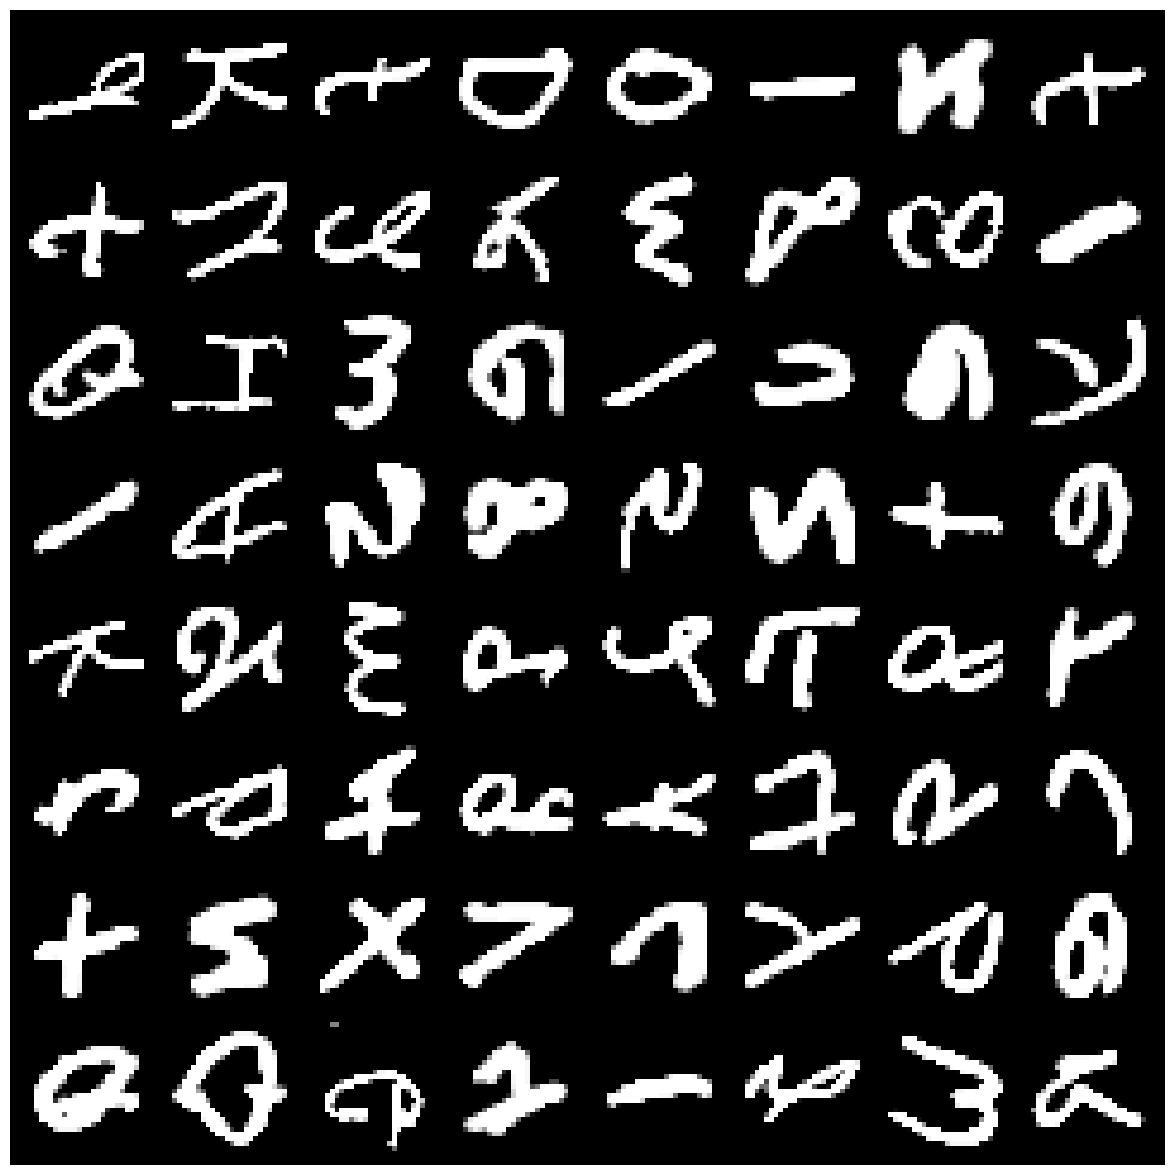

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
from utils import save_checkpoint, load_checkpoint

def set_seed(seed):
    """Set seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)
torch.backends.cudnn.benchmark = True

# Data loading code remains the same
def get_data_loaders(batch_size: int, num_workers: int = 4):
    """
    Create data loaders for EMNIST dataset.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1751,), (0.3332,))  # EMNIST mean and std
    ])
    
    # Using balanced split (47 classes)
    train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
    val_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader

def visualize_batch(dataloader):
    inputs, _ = next(iter(dataloader))
    out = vutils.make_grid(inputs)

    plt.figure(figsize=(15, 15))
    if out.shape[0] == 1:
        plt.imshow(out.squeeze().cpu(), cmap='gray')
    else:
        plt.imshow(out.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
    plt.close()


# Hyperparameters
NUM_CLASSES : int = 47  # EMNIST balanced split has 47 classes
BATCH_SIZE : int= 64
NUM_EPOCHS : int = 20
LEARNING_RATE : float = 0.001
CHECKPOINT_DIR : str = 'checkpoints'
LATEST_MODEL : str = 'latest_model_checkpoint.pth'
BEST_MODEL : str = 'best_model_checkpoint.pth'


train_loader, val_loader = get_data_loaders(BATCH_SIZE)
print(f'number of training images: {len(train_loader.dataset)}')
print(f'number of validation images: {len(val_loader.dataset)}')

visualize_batch(train_loader)

In [ ]:
from cnn_model import ResidualCNN

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    checkpoint_dir: str = 'checkpoints'
) -> dict:
    """
    Train the model with checkpoint support.
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    criterion = nn.CrossEntropyLoss()
    
    # Load checkpoint if available
    start_epoch, train_losses, train_accuracies, val_losses, val_accuracies, best_val_accuracy = load_checkpoint(
        model, optimizer, scheduler, checkpoint_dir, model_name=LATEST_MODEL
    )
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }
    
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({'loss': train_loss/len(train_loader), 'acc': 100.*correct/total})
        
        train_acc = 100. * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Check if this is the best model
        is_best = val_acc > best_val_accuracy
        if is_best:
            best_val_accuracy = val_acc
        
        # Save checkpoint
        save_checkpoint(
            epoch + 1,  # Save next epoch number
            model,
            optimizer,
            history['train_loss'],
            history['train_acc'],
            history['val_loss'],
            history['val_acc'],
            best_val_accuracy,
            is_best,
            checkpoint_dir,
            latest_path = LATEST_MODEL,
            best_path = LATEST_MODEL
        )
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n')
    
    return history

# Create model and data loaders
model = ResidualCNN(
    num_classes=NUM_CLASSES,
    initial_channels=64,
    num_layers=3,
    dropout_rate=0.5
)

# Train model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    checkpoint_dir=CHECKPOINT_DIR
)

print("Training completed!")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")

Epoch 1/20:  20%|██        | 354/1763 [02:59<10:38,  2.21it/s, loss=0.518, acc=23.7]  

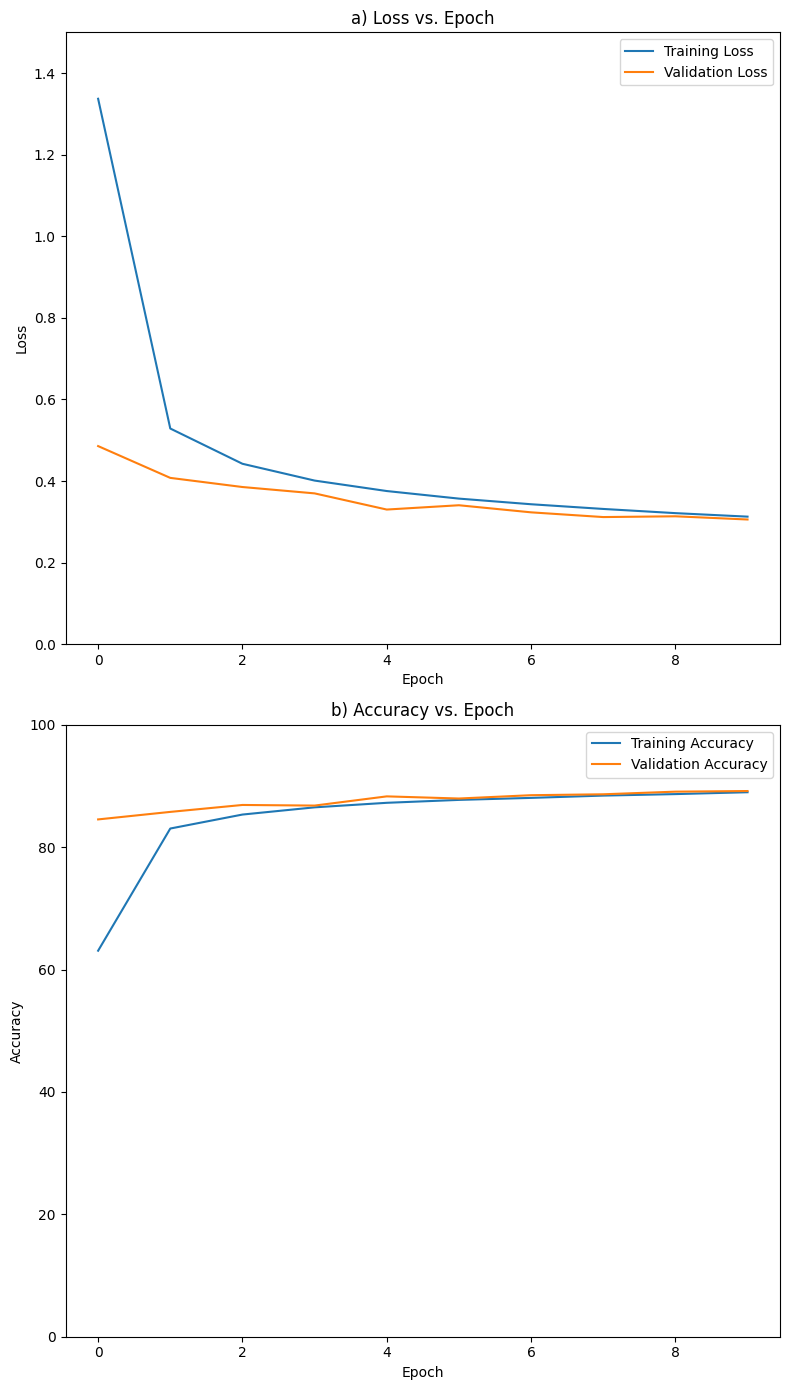

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 14))

# Loss vs. Epoch
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('a) Loss vs. Epoch')
ax1.set_ylim(0.0, 1.5)

# Accuracy vs. Epoch
ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('b) Accuracy vs. Epoch')
ax2.set_ylim(0.0, 100)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()